# Marketing Campaign Creatives Generation Agent

Interactive LangGraph-based AI Agent for Marketing Content Generation.

This notebook implements an intelligent agent that:
- Takes short user inputs and expands them into detailed prompts
- Generates promotional images using Imagen 3.0
- Generates promotional videos using Veo 3.1
- Allows iterative feedback and refinement

## Installing the Necessary Libraries

In [1]:
!pip install -q -U google-genai langgraph langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.1/719.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.4/157.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.43.0, but you have google-auth 2.47.0 which is incompatible.


**Note:** After running the above cell, kindly restart the runtime and run all cells sequentially from the next cell.

## Importing Libraries

In [2]:
# Google Generative AI Libraries
from google import genai
from google.genai import types

# LangGraph Libraries
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# LangChain Core
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

# Type Annotations
from typing import TypedDict, Annotated, Literal, Optional, List, Any

# Utility Libraries
import os
import sys
import time
import matplotlib.pyplot as plt

## Authentication and Client Setup

In [3]:
# Authenticate the user for Google Cloud services
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [4]:
# Set Google Cloud project details
PROJECT_ID = "my-gcp-project-code"  # @param {type: "string"}
LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

# Initialize the client for GenAI with project and location details
client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

# Model identifiers
IMAGE_MODEL = "imagen-3.0-generate-001"
VIDEO_MODEL = "veo-3.1-fast-generate-001"
GEMINI_MODEL = "gemini-2.0-flash"

# Configuration constants
MAX_ITERATIONS = 10

## Agent State Schema Definition

In [5]:
class AgentState(TypedDict):
    """
    State schema for the marketing content generation agent.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    user_input: str
    feedback: Optional[str]
    expanded_image_prompt: Optional[str]
    expanded_video_prompt: Optional[str]
    generation_mode: Optional[Literal["image", "video", "both"]]
    generated_image: Optional[Any]
    generated_video_path: Optional[str]
    iteration_count: int
    is_satisfied: bool

## Tool Implementations

In [7]:
def expand_prompt(state: AgentState) -> dict:
    """
    Uses Gemini to expand a short user input into detailed image and video prompts.
    """
    user_input = state["user_input"]

    system_prompt = """You are an expert at creating detailed prompts for AI image and video generation.
Given a short description of promotional material needed, create TWO detailed prompts:

1. IMAGE PROMPT: A detailed description for generating a promotional poster/image.
   Include: visual style, colors, composition, text elements, mood, and specific details.

2. VIDEO PROMPT: A detailed description for generating an 8-second promotional video.
   Include: scene descriptions, camera movements, pacing, mood, and any text overlays.

Format your response EXACTLY as:
IMAGE_PROMPT: [detailed image prompt here]
VIDEO_PROMPT: [detailed video prompt here - NO PEOPLE]
"""

    response = client.models.generate_content(
        model=GEMINI_MODEL,
        contents=[{"role": "user", "parts": [{"text": f"{system_prompt}\n\nUser request: {user_input}"}]}]
    )

    response_text = response.text
    image_prompt = ""
    video_prompt = ""

    if "IMAGE_PROMPT:" in response_text and "VIDEO_PROMPT:" in response_text:
        parts = response_text.split("VIDEO_PROMPT:")
        image_prompt = parts[0].replace("IMAGE_PROMPT:", "").strip()
        if len(parts) > 1:
            video_prompt = parts[1].strip()

    print("\n" + "-"*50)
    print("EXPANDED PROMPTS")
    print("-"*50)
    print(f"\nImage Prompt Preview:\n{image_prompt[:300]}...")
    print(f"\nVideo Prompt Preview:\n{video_prompt[:300]}...")

    return {
        "expanded_image_prompt": image_prompt,
        "expanded_video_prompt": video_prompt,
        "messages": [AIMessage(content="Expanded your request into detailed prompts.")]
    }

In [8]:
def generate_poster(state: AgentState) -> dict:
    """
    Generates a promotional image using Imagen 3.0.
    """
    prompt = state.get("expanded_image_prompt")

    if not prompt:
        print("Error: No image prompt available.")
        return {"messages": [AIMessage(content="Error: No image prompt available.")]}

    print("\nGenerating image with Imagen 3.0...")

    try:
        response = client.models.generate_images(
            model=IMAGE_MODEL,
            prompt=prompt,
            config=types.GenerateImagesConfig(number_of_images=1)
        )
        img = response.generated_images[0].image
        print("Image generated successfully!")
        return {"generated_image": img, "messages": [AIMessage(content="Image generated!")]}
    except Exception as e:
        print(f"Error generating image: {str(e)}")
        return {"messages": [AIMessage(content=f"Error: {str(e)}")]}

In [9]:
def generate_video(state: AgentState) -> dict:
    """
    Generates a promotional video using Veo 3.1 with async polling.
    """
    prompt = state.get("expanded_video_prompt")
    iteration = state.get("iteration_count", 0)

    if not prompt:
        print("Error: No video prompt available.")
        return {"messages": [AIMessage(content="Error: No video prompt available.")]}

    print("\nGenerating video with Veo 3.1... (this may take a few minutes)")
    print(f"Video prompt: {prompt[:200]}...")

    try:
        operation = client.models.generate_videos(
            model=VIDEO_MODEL,
            prompt=prompt,
            config=types.GenerateVideosConfig(
                aspect_ratio="9:16",
                number_of_videos=1,
                duration_seconds=8,
                person_generation="allow",
                enhance_prompt=True,
            ),
        )

        while not operation.done:
            time.sleep(15)
            operation = client.operations.get(operation)
            print(f"  Status: {operation}")

        # Debug: print full operation details
        print(f"\nOperation completed. Response: {operation.response}")

        # Check if operation completed successfully (matching original code pattern)
        if operation.response:
            try:
                generated_video = operation.result.generated_videos[0].video
                video_filename = f"promotional_video_v{iteration + 1}.mp4"
                generated_video.save(video_filename)
                print(f"Video saved as: {video_filename}")
                return {"generated_video_path": video_filename, "messages": [AIMessage(content=f"Video saved: {video_filename}")]}
            except (IndexError, AttributeError, TypeError) as e:
                # Check for rai_media_filtered_reasons (content policy)
                if hasattr(operation.result, 'rai_media_filtered_reasons'):
                    reasons = operation.result.rai_media_filtered_reasons
                    print(f"Video filtered by content policy: {reasons}")
                    return {"messages": [AIMessage(content=f"Video blocked by content policy: {reasons}")]}
                else:
                    print(f"Could not extract video: {e}")
                    print(f"Operation result: {operation.result}")
                    return {"messages": [AIMessage(content=f"Video extraction failed: {e}")]}
        else:
            print(f"No response. Operation: {operation}")
            return {"messages": [AIMessage(content="Video generation returned no response.")]}

    except Exception as e:
        print(f"Error generating video: {str(e)}")
        return {"messages": [AIMessage(content=f"Error: {str(e)}")]}

In [10]:
def modify_prompt(state: AgentState) -> dict:
    """
    Takes user feedback and modifies existing prompts accordingly.
    """
    feedback = state.get("feedback", "")
    current_image_prompt = state.get("expanded_image_prompt", "")
    current_video_prompt = state.get("expanded_video_prompt", "")
    generation_mode = state.get("generation_mode", "both")

    system_prompt = f"""You are an expert at refining AI generation prompts based on user feedback.

Current image prompt:
{current_image_prompt}

Current video prompt:
{current_video_prompt}

User feedback: {feedback}

Please modify the prompts to incorporate this feedback while preserving the core concept.

CRITICAL RULE FOR VIDEO: Do NOT include any people, humans, faces, hands, baristas, customers,
or any human figures in the video prompt. Focus ONLY on products, environment, objects, textures,
abstract visuals, motion graphics, and text overlays.

Format your response EXACTLY as:
IMAGE_PROMPT: [modified image prompt]
VIDEO_PROMPT: [modified video prompt - NO PEOPLE]
"""

    response = client.models.generate_content(
        model=GEMINI_MODEL,
        contents=[{"role": "user", "parts": [{"text": system_prompt}]}]
    )

    response_text = response.text
    new_image_prompt = current_image_prompt
    new_video_prompt = current_video_prompt

    if "IMAGE_PROMPT:" in response_text and "VIDEO_PROMPT:" in response_text:
        parts = response_text.split("VIDEO_PROMPT:")
        img_part = parts[0].replace("IMAGE_PROMPT:", "").strip()
        if img_part:
            new_image_prompt = img_part
        if len(parts) > 1:
            vid_part = parts[1].strip()
            if vid_part:
                new_video_prompt = vid_part

    print(f"\nPrompts updated based on feedback: '{feedback}'")

    return {
        "expanded_image_prompt": new_image_prompt,
        "expanded_video_prompt": new_video_prompt,
        "iteration_count": state.get("iteration_count", 0) + 1,
        "messages": [AIMessage(content="Prompts updated.")]
    }

## Node Function Definitions

In [11]:
def get_user_input_node(state: AgentState) -> dict:
    """Initial node to get user's creative brief."""
    print("\n" + "="*60)
    print("   MARKETING CONTENT GENERATION AGENT")
    print("   Powered by LangGraph, Gemini, Imagen 3.0 & Veo 3.1")
    print("="*60)

    user_input = input("\nDescribe what promotional material you need\n(e.g., 'coffee shop promotional material'): ").strip()

    if not user_input:
        user_input = "general business promotional material"

    return {
        "user_input": user_input,
        "iteration_count": 0,
        "is_satisfied": False,
        "messages": [HumanMessage(content=user_input)]
    }


def expand_prompt_node(state: AgentState) -> dict:
    """Node that calls the expand_prompt tool."""
    return expand_prompt(state)


def ask_generation_mode_node(state: AgentState) -> dict:
    """Ask user what type of content to generate."""
    print("\n" + "-"*50)
    print("GENERATION OPTIONS")
    print("-"*50)
    print("\nWhat would you like to generate?")
    print("  1. Image only")
    print("  2. Video only")
    print("  3. Both image and video")

    choice = input("\nEnter your choice (1/2/3): ").strip()
    mode_map = {"1": "image", "2": "video", "3": "both"}
    mode = mode_map.get(choice, "both")

    print(f"\nSelected: {mode}")
    return {"generation_mode": mode, "messages": [HumanMessage(content=f"Generate: {mode}")]}

In [12]:
def display_image(img, title="Generated Image"):
    """Display image in Colab/Jupyter notebook."""
    print(f"\n{title}:")
    try:
        # The Google GenAI image object has a show() method
        img.show()
    except Exception as e1:
        try:
            # Try saving to file (Google's image object has save method without format arg)
            filename = "generated_image.png"
            img.save(filename)
            print(f"Image saved as: {filename}")

            # Display from file in Colab
            from IPython.display import display, Image as IPImage
            display(IPImage(filename=filename))
        except Exception as e2:
            print(f"Could not display image: {e2}")
            print("Image object available in final_state['generated_image']")


def display_video_in_notebook(video_path):
    """Display video in Jupyter/Colab notebook."""
    try:
        from IPython.display import Video, display
        display(Video(video_path, embed=True, height=500))
    except Exception as e:
        print(f"Could not display video inline: {e}")
        print(f"Video saved at: {video_path}")

In [13]:
def generate_content_node(state: AgentState) -> dict:
    """Routes to appropriate generation based on mode."""
    mode = state.get("generation_mode", "both")
    results = {}

    print("\n" + "-"*50)
    print("GENERATING CONTENT")
    print("-"*50)

    if mode in ["image", "both"]:
        img_result = generate_poster(state)
        results.update(img_result)
        if img_result.get("generated_image"):
            display_image(img_result["generated_image"], "Generated Promotional Image")

    if mode in ["video", "both"]:
        vid_result = generate_video(state)
        results.update(vid_result)
        if vid_result.get("generated_video_path"):
            display_video_in_notebook(vid_result["generated_video_path"])

    return results


def collect_feedback_node(state: AgentState) -> dict:
    """Collect user feedback on generated content."""
    iteration = state.get("iteration_count", 0)

    if iteration >= MAX_ITERATIONS:
        print(f"\nMaximum iterations ({MAX_ITERATIONS}) reached.")
        return {"is_satisfied": True, "messages": [AIMessage(content="Max iterations reached.")]}

    print("\n" + "-"*50)
    print("FEEDBACK")
    print("-"*50)
    print("\nAre you satisfied with the generated content?")
    print("  - Type 'yes' or 'done' if satisfied")
    print("  - Or provide feedback (e.g., 'make it more colorful')")

    feedback = input("\nYour response: ").strip()

    if feedback.lower() in ["yes", "done", "satisfied", "looks good", "perfect", "ok", "okay", "y"]:
        return {"is_satisfied": True, "messages": [HumanMessage(content="Satisfied.")]}
    else:
        return {"feedback": feedback, "is_satisfied": False, "messages": [HumanMessage(content=f"Feedback: {feedback}")]}


def modify_prompt_node(state: AgentState) -> dict:
    """Node that calls the modify_prompt tool."""
    return modify_prompt(state)

## Graph Construction

In [14]:
def build_agent_graph() -> StateGraph:
    """
    Builds the LangGraph agent with all nodes and edges.

    Graph Structure:
    START --> get_user_input --> expand_prompt --> ask_generation_mode
                                                         |
                                                         v
                                              generate_content
                                                         |
                                                         v
                                              collect_feedback
                                                    /    \
                                           [satisfied]  [feedback]
                                                /            \
                                              END        modify_prompt
                                                              |
                                                              v
                                                    generate_content (loop)
    """
    graph = StateGraph(AgentState)

    # Add all nodes
    graph.add_node("get_user_input", get_user_input_node)
    graph.add_node("expand_prompt", expand_prompt_node)
    graph.add_node("ask_generation_mode", ask_generation_mode_node)
    graph.add_node("generate_content", generate_content_node)
    graph.add_node("collect_feedback", collect_feedback_node)
    graph.add_node("modify_prompt", modify_prompt_node)

    # Add edges
    graph.add_edge(START, "get_user_input")
    graph.add_edge("get_user_input", "expand_prompt")
    graph.add_edge("expand_prompt", "ask_generation_mode")
    graph.add_edge("ask_generation_mode", "generate_content")
    graph.add_edge("generate_content", "collect_feedback")

    # Conditional edge for feedback loop
    def route_after_feedback(state: AgentState) -> str:
        if state.get("is_satisfied", False):
            return "end"
        else:
            return "modify"

    graph.add_conditional_edges(
        "collect_feedback",
        route_after_feedback,
        {"end": END, "modify": "modify_prompt"}
    )

    graph.add_edge("modify_prompt", "generate_content")

    return graph.compile()

## Run the Agent

In [15]:
def run_agent():
    """Main entry point for the marketing content generation agent."""
    agent = build_agent_graph()

    initial_state = {
        "messages": [],
        "user_input": "",
        "feedback": None,
        "expanded_image_prompt": None,
        "expanded_video_prompt": None,
        "generation_mode": None,
        "generated_image": None,
        "generated_video_path": None,
        "iteration_count": 0,
        "is_satisfied": False,
    }

    try:
        final_state = agent.invoke(initial_state)

        print("\n" + "="*60)
        print("   GENERATION COMPLETE")
        print("="*60)
        print(f"\nTotal iterations: {final_state.get('iteration_count', 0) + 1}")

        if final_state.get("generated_image"):
            print("Image: Generated successfully")
        if final_state.get("generated_video_path"):
            print(f"Video: {final_state['generated_video_path']}")

        print("\nThank you for using the Marketing Content Generator!")
        return final_state

    except KeyboardInterrupt:
        print("\n\nAgent interrupted.")
        return None
    except Exception as e:
        print(f"\n\nError: {str(e)}")
        return None


   MARKETING CONTENT GENERATION AGENT
   Powered by LangGraph, Gemini, Imagen 3.0 & Veo 3.1

Describe what promotional material you need
(e.g., 'coffee shop promotional material'): coffee shop downtown toronto

--------------------------------------------------
EXPANDED PROMPTS
--------------------------------------------------

Image Prompt Preview:
A vibrant and inviting promotional poster for a downtown Toronto coffee shop. Visual style: A blend of hand-drawn illustration and modern, clean design. The backdrop features a stylized Toronto skyline with iconic landmarks like the CN Tower subtly incorporated. Colors: Warm, earthy tones (browns, c...

Video Prompt Preview:
An 8-second promotional video for a downtown Toronto coffee shop. Scene 1 (0-2 seconds): Close-up of freshly ground coffee beans being poured into a portafilter. Focus is tight, showcasing the rich texture and color of the beans. Camera movement: Slow, deliberate zoom in on the portafilter. Scene 2 ...

--------------

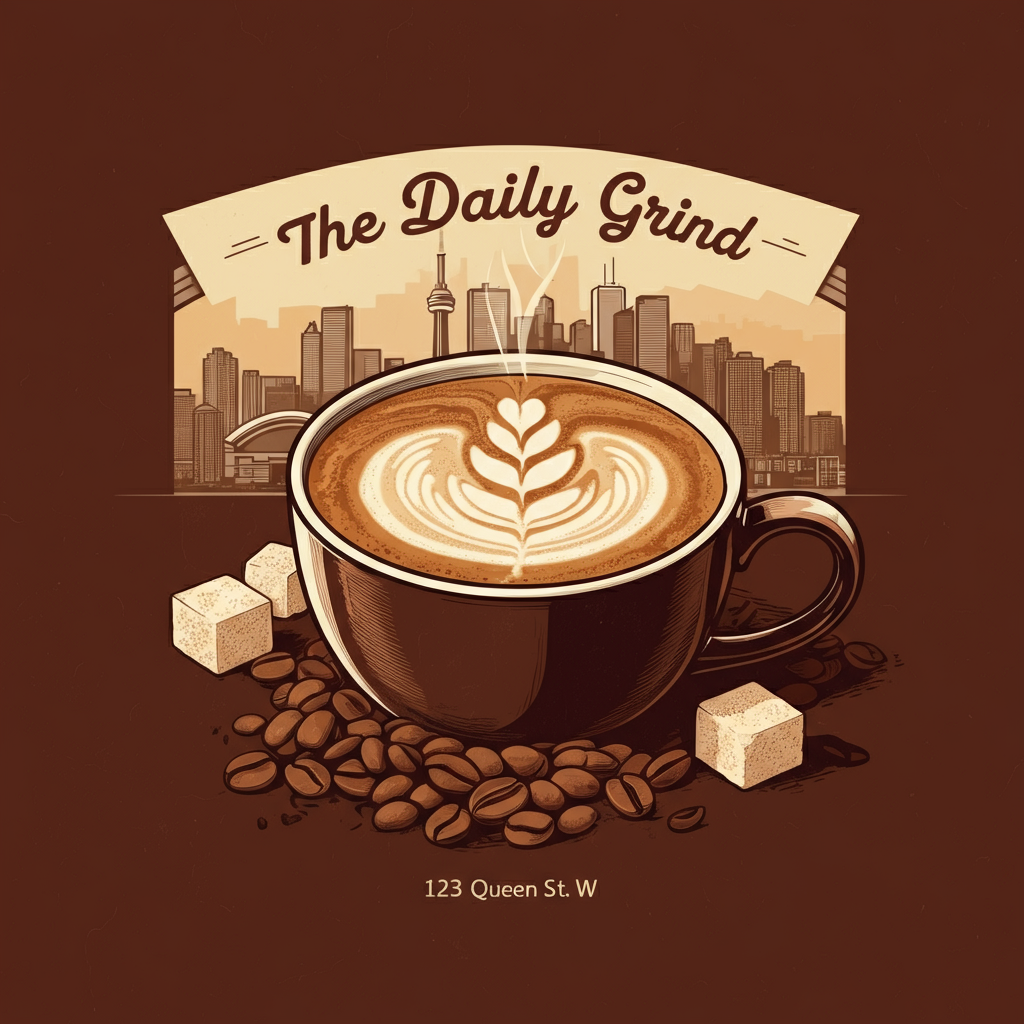


Generating video with Veo 3.1... (this may take a few minutes)
Video prompt: An 8-second promotional video for a downtown Toronto coffee shop. Scene 1 (0-2 seconds): Close-up of freshly ground coffee beans being poured into a portafilter. Focus is tight, showcasing the rich te...
  Status: name='projects/educational-project-475520/locations/us-central1/publishers/google/models/veo-3.1-fast-generate-001/operations/5e78eb79-3dda-4b9f-928f-c1353b6c6395' metadata=None done=None error=None response=None result=None
  Status: name='projects/educational-project-475520/locations/us-central1/publishers/google/models/veo-3.1-fast-generate-001/operations/5e78eb79-3dda-4b9f-928f-c1353b6c6395' metadata=None done=None error=None response=None result=None
  Status: name='projects/educational-project-475520/locations/us-central1/publishers/google/models/veo-3.1-fast-generate-001/operations/5e78eb79-3dda-4b9f-928f-c1353b6c6395' metadata=None done=None error=None response=None result=None
  Status: nam


--------------------------------------------------
FEEDBACK
--------------------------------------------------

Are you satisfied with the generated content?
  - Type 'yes' or 'done' if satisfied
  - Or provide feedback (e.g., 'make it more colorful')

Your response: done

   GENERATION COMPLETE

Total iterations: 1
Image: Generated successfully
Video: promotional_video_v1.mp4

Thank you for using the Marketing Content Generator!


In [16]:
# Run the agent
final_state = run_agent()